In [ ]:
from capstone_data_eng import *
import seaborn as sns
import statsmodels.api as sm

### Library versions

#### Tested environment



In [1]:
import pandas as pd
import sklearn
import statsmodels

print('pandas: ',pd.__version__)
print('sklearn: ',sklearn.__version__)
print('statsmodels: ',statsmodels.__version__)



pandas:  0.24.2
sklearn:  0.21.2
statsmodels:  0.9.0


## Load the data 

In [7]:
out, profile_all, portfolio, offers_all, transactions_all, transactions_during_offer, transactions_outside_offer = load_data_cv(
        person_split=None, rename_offers=True, time_split_min=None, time_split_max=None,
        add_transactions=False, skip_overlap=False, skip_add_purchases=False, calc_net_offer_time=True,
        assign_to='ignore', location='local')

TypeError: invalid type <class 'pandas.core.arrays.categorical.Categorical'> for astype

# Feature engineering

In [3]:
out.columns

NameError: name 'out' is not defined

In [12]:
out['binned_income'] = pd.cut(out['income'],bins= np.arange(0,14)*1e4,labels=np.arange(0,13)*10)
out['binned_age'] = pd.cut(out['age'],bins= np.arange(0,120,10) ,labels=np.arange(0,120,10)[:-1])

In [ ]:
c_drop=['person','offer', 'became_member_on',]

c_bin=['web', 'email', 'mobile', 'social','viewed', 'rewarded',
       'received', 'comp_not_viewed', 'completed']

c_num_time=['offer_received', 'offer_viewed', 'offer_completed', 'offer_end']
c_num_offer=['reward','difficulty', 'duration', 'offer_reward', 'duration_hours',
       'duration_viewed', 'duration_effective', 'overlaps',]
c_num_offer_leak=['Tpay_offer', 'Npay_offer','Maxpay_offer', 'Minpay_offer', 
                  'Netpay_offer', 'Avg_pay_offer', 'income', 'joined_year', 'joined_month',
       'joined_week', 'gender_num', 'user_time',  'p_c_r_ratio', 'p_cnv_r_ratio', 'p_c_v_ratio' ]
c_num_offers_leak=['Tpay_offers_tot', 'Npay_offers_tot', 'Maxpay_offers_tot',
       'Minpay_offers_tot', 'Trewards_tot', 'Nrewards_tot',
       'tot_gross_offer_time', 'tot_net_offers_time', 'tot_not_offers_time',
       'Avg_pay_offers', 'Net_pay_offers', 'Avg_net_pay_offers',
       'Avg_pay_outside', 'Avg_D_O', 'Avg_D_OS', 'Avg_D_nOS']


c_cat_offer=['offer_type', ]
c_num_person=['age', 'Tpay_out', 'Npay_out', ]
c_cat_person=['gender',]



c_all=c_drop+c_bin+c_num_time+c_num_offer+c_num_offer_leak+c_num_offers_leak +\
  c_cat_offer+c_num_person+c_cat_person

In [ ]:
print('missing columns from out / c_all')
print( set(out.columns ) ^ set(c_all) )

missing columns from out / c_all
set()


In [ ]:
out.loc[out.gender.isna(),'gender']='M'
out.loc[out.income.isna(),'income']=out.income.median()
out[['offer_viewed', 'offer_completed']]=out[['offer_viewed', 'offer_completed']].fillna(-1)

In [ ]:
print("columns with nans", list( out.columns[out.isna().any()] ))

columns with nans []


# EDA: Offers database

The database 'portfolio' is used as it is except for renaming the hash-id to a shorthand (a,b,c,d...) to simplify plotting.

In [2]:
display(portfolio)

NameError: name 'portfolio' is not defined

Text(0, 0.5, 'percentage of completed offers')

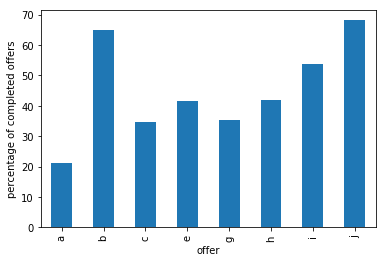

In [ ]:
o_cmp_ratio=out.groupby(by='offer')['completed'].value_counts(normalize=True)
o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values('completed')==True,:]
o_cmp=100.*o_cmp.droplevel(level='completed')
o_cmp.plot(kind='bar')
plt.ylabel('percentage of completed offers')


Text(0, 0.5, 'percentage of completed offers')

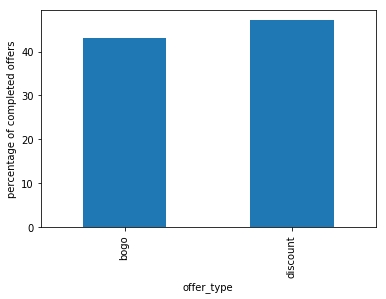

In [ ]:
o_cmp_ratio=out.groupby(by='offer_type')['completed'].value_counts(normalize=True)
o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values('completed')==True,:]
o_cmp=100.*o_cmp.droplevel(level='completed')
o_cmp.plot(kind='bar')
plt.ylabel('percentage of completed offers')

Text(0, 0.5, 'percentage of completed offers')

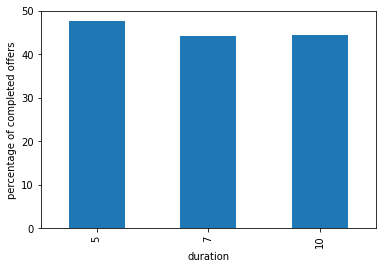

In [ ]:
o_cmp_ratio=out.groupby(by='duration')['completed'].value_counts(normalize=True)
o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values('completed')==True,:]
o_cmp=100.*o_cmp.droplevel(level='completed')
o_cmp.plot(kind='bar')
plt.ylabel('percentage of completed offers')

Text(0, 0.5, 'percentage of completed offers')

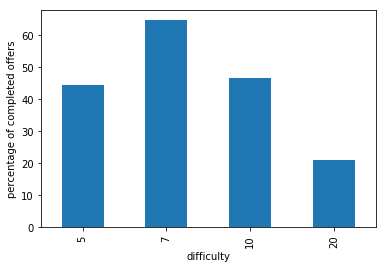

In [ ]:
o_cmp_ratio=out.groupby(by='difficulty')['completed'].value_counts(normalize=True)
o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values('completed')==True,:]
o_cmp=100.*o_cmp.droplevel(level='completed')
o_cmp.plot(kind='bar')
plt.ylabel('percentage of completed offers')

Text(0, 0.5, 'percentage of completed offers')

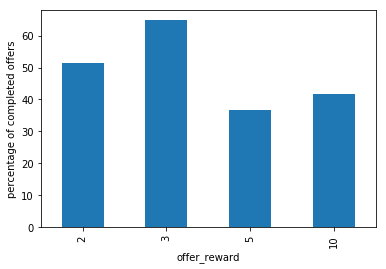

In [ ]:
o_cmp_ratio=out.groupby(by='offer_reward')['completed'].value_counts(normalize=True)
o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values('completed')==True,:]
o_cmp=100.*o_cmp.droplevel(level='completed')
o_cmp.plot(kind='bar')
plt.ylabel('percentage of completed offers')

Text(0, 0.5, 'percentage of completed offers')

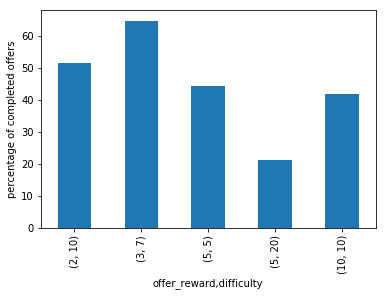

In [ ]:
o_cmp_ratio=out.groupby(by=['offer_reward','difficulty'])['completed'].value_counts(normalize=True)
o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values('completed')==True,:]
o_cmp=100.*o_cmp.droplevel(level='completed')
o_cmp.plot(kind='bar')
plt.ylabel('percentage of completed offers')


Text(0, 0.5, 'percentage of completed offers')

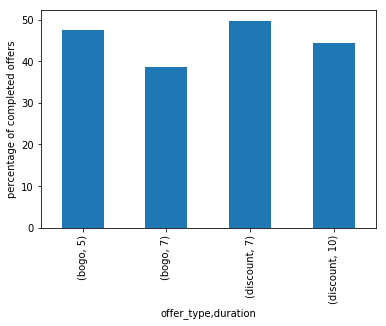

In [ ]:
o_cmp_ratio=out.groupby(by=['offer_type','duration'])['completed'].value_counts(normalize=True)
o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values('completed')==True,:]
o_cmp=100.*o_cmp.droplevel(level='completed')
o_cmp.plot(kind='bar')
plt.ylabel('percentage of completed offers')

Text(0.5, 1.0, 'social channel has significant impact')

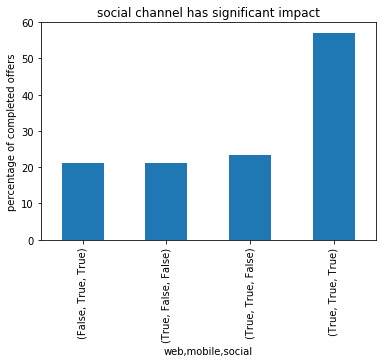

In [ ]:
o_cmp_ratio=out.groupby(by=['web','mobile','social'])['completed'].value_counts(normalize=True)
o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values('completed')==True,:]
o_cmp=100.*o_cmp.droplevel(level='completed')
o_cmp.plot(kind='bar')
plt.ylabel('percentage of completed offers')

plt.title('social channel has significant impact')

Text(0.5, 1.0, 'social channel has significant impact')

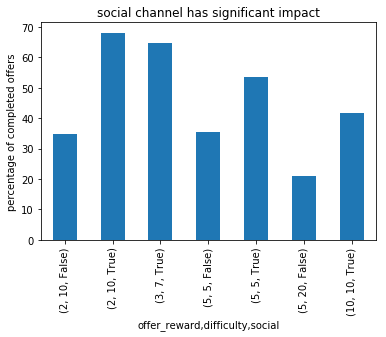

In [ ]:
o_cmp_ratio=out.groupby(by=['offer_reward','difficulty','social'])['completed'].value_counts(normalize=True)
o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values('completed')==True,:]
o_cmp=100.*o_cmp.droplevel(level='completed')
o_cmp.plot(kind='bar')
plt.ylabel('percentage of completed offers')

plt.title('social channel has significant impact')

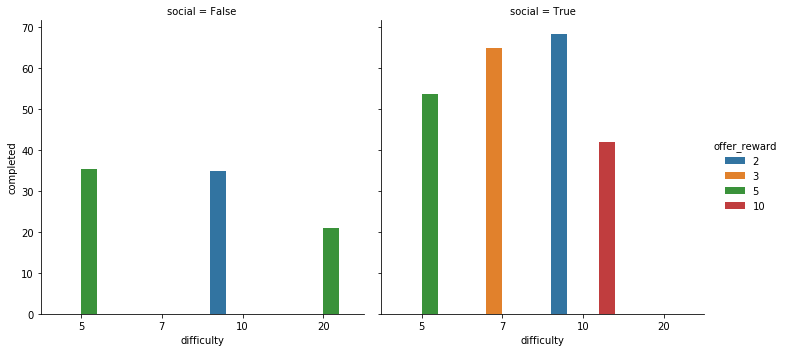

In [ ]:
o_cmp_ratio=out.groupby(by=['offer_reward','difficulty','social'])['completed'].value_counts(normalize=True)
o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values('completed')==True,:]
o_cmp=100.*o_cmp.droplevel(level='completed').to_frame()
o_cmp=o_cmp.stack().reset_index().drop(columns=['level_3']).rename(columns={0:'completed'})
o_cmp

sns.catplot(x='difficulty',y='completed',hue='offer_reward',col='social',data=o_cmp,kind='bar')

In [ ]:
def cmp_facets(out,var1,var2,var3,col):
  o_cmp_ratio=out.groupby(by=[var1,var2,var3])[col].value_counts(normalize=True)
  o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values(col)==True,:]
  o_cmp=100.*o_cmp.droplevel(level=col).to_frame()
  o_cmp=o_cmp.stack().reset_index().drop(columns=['level_3']).rename(columns={0:col})
  o_cmp

  sns.catplot(x=var1,y=col,hue=var2,col=var3,data=o_cmp,kind='bar')  

,web,mobile,social,completed
0,False,True,True,21.065724
1,True,False,False,21.035472
2,True,True,False,23.397016
3,True,True,True,57.078962


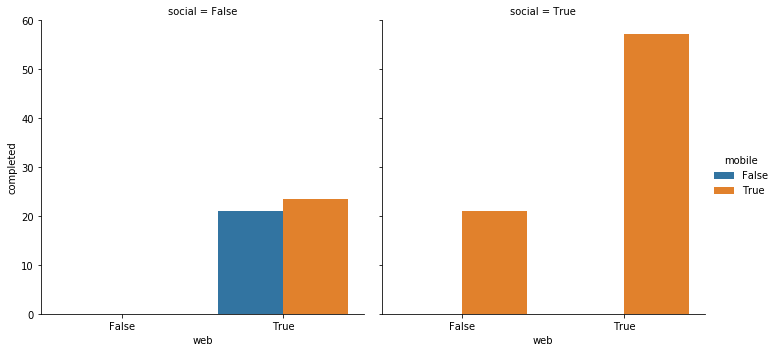

In [ ]:
o_cmp_ratio=out.groupby(by=['web','mobile','social'])['completed'].value_counts(normalize=True)
o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values('completed')==True,:]
o_cmp=100.*o_cmp.droplevel(level='completed').to_frame()
o_cmp=o_cmp.stack().reset_index().drop(columns=['level_3']).rename(columns={0:'completed'})
display(o_cmp)

sns.catplot(x='web',y='completed',hue='mobile',col='social',data=o_cmp,kind='bar')  

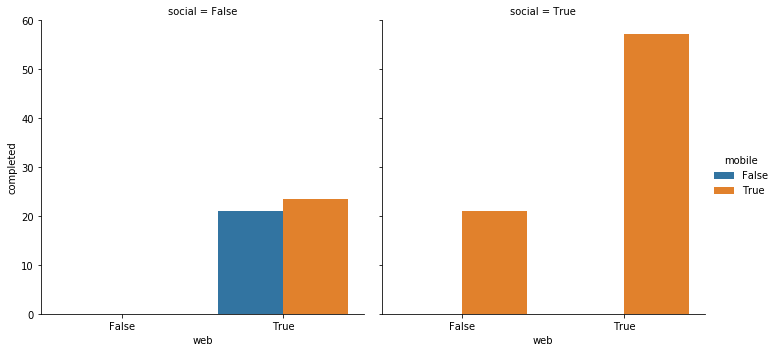

In [ ]:
cmp_facets(out,'web','mobile','social','completed')

In [ ]:
out['web_social']=out['web'] & out['social']
out['dd']=out['difficulty']/out['duration']

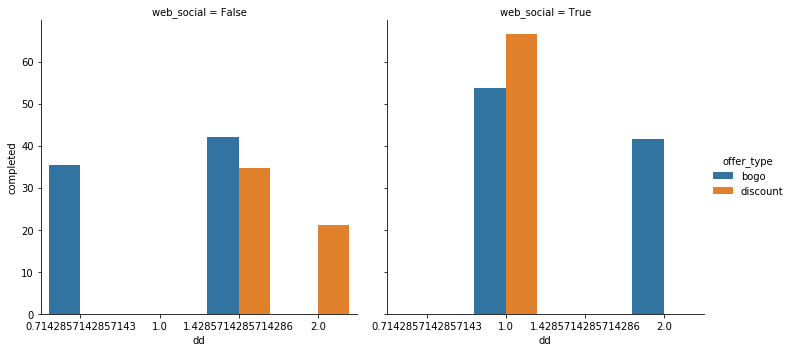

In [ ]:
cmp_facets(out,'dd','offer_type','web_social','completed')



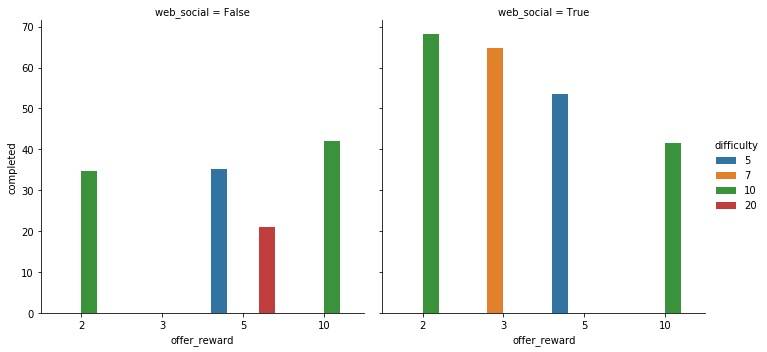

In [ ]:
cmp_facets(out,'offer_reward','difficulty','web_social','completed')

Text(406.69322265625004, 0.5, '% completed')

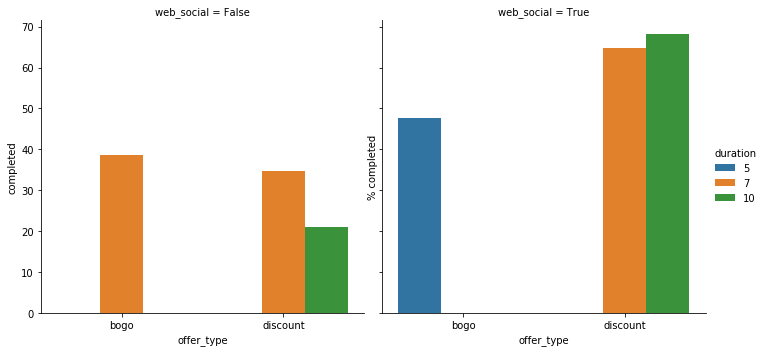

In [ ]:
cmp_facets(out,'offer_type','duration','web_social','completed');


In [ ]:
o_cmp_ratio=out.groupby(by=['web','mobile','social','web_social','offer_type','duration','difficulty','offer_reward'])['completed'].value_counts(normalize=True)
o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values('completed')==True,:]
o_cmp=100.*o_cmp.droplevel(level='completed').to_frame()
o_cmp=o_cmp.stack().reset_index().drop(columns=['level_8']).rename(columns={0:'completed'})

In [ ]:
o_cmp['bogo']=o_cmp.offer_type=='bogo'
o_cmp[['web','mobile','social','web_social','bogo']]=o_cmp[['web','mobile','social','web_social','bogo']].astype(int)


In [ ]:
o_cmp

,web,mobile,social,web_social,offer_type,duration,difficulty,offer_reward,completed,bogo
0,0,1,1,0,bogo,7,10,10,42.021416,1
1,1,0,0,0,discount,10,20,5,21.035472,0
2,1,1,0,0,bogo,7,5,5,35.300247,1
3,1,1,0,0,discount,7,10,2,34.774633,0
4,1,1,1,1,bogo,5,5,5,53.652094,1
5,1,1,1,1,bogo,5,10,10,41.643619,1
6,1,1,1,1,discount,7,7,3,64.818206,0
7,1,1,1,1,discount,10,10,2,68.132157,0


In [ ]:
import statsmodels.api as sm

X = sm.add_constant(X)
Y=o_cmp["completed"]
linear = sm.OLS(endog=Y,exog=X   ).fit()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [ ]:
X=out[['web','mobile','social','web_social','offer_type',"duration","difficulty","offer_reward"]].copy()
X['bogo']=X['offer_type']=='bogo'
X=X.drop(columns=['offer_type'])
X[['web','mobile','social','web_social','bogo']]=X[['web','mobile','social','web_social','bogo']].astype(int)
X = sm.add_constant(X)
Y=out['completed'].astype(int)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [ ]:
from  statsmodels.discrete.discrete_model import Logit

logit = Logit(Y, X)
logit.fit().params

Optimization terminated successfully.
         Current function value: 0.535867
         Iterations 9


const          -5.466669
web            -1.412700
mobile          2.557929
social         -1.413125
web_social      2.640845
duration        0.339761
difficulty      0.132373
offer_reward   -0.097698
bogo            1.128060
dtype: float64

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept = False, C = 1e9)
mdl = model.fit(X, Y)
print(model.coef_)
print(model.score(X,Y))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[-5.46664386 -1.41269695  2.55791845 -1.41311354  2.64083337  0.33975876
   0.132373   -0.09769883  1.12805761]]
0.658284935170497


In [ ]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X, Y)
print(reg.score(X, Y))



1.0


In [ ]:
print(reg.coef_)
print(X.columns)

[ 0.          5.62447492  1.37797084 24.35411734 -8.45160103  3.00113566
 -2.0227875  -0.37890737]
Index(['const', 'web', 'mobile', 'social', 'bogo', 'duration', 'difficulty',
       'offer_reward'],
      dtype='object')


In [ ]:
to=out.groupby(by='person')['tot_gross_offer_time','tot_net_offers_time','tot_not_offers_time'].agg('mean')
to=to.sum()

display(to)

display(to['tot_net_offers_time']/to['tot_gross_offer_time'])
# plt.ylabel('number of offers sent');

tot_gross_offer_time    7306986.0
tot_net_offers_time     6259952.0
tot_not_offers_time     6383584.0
dtype: float64

0.8567078135909936

In [ ]:
print(1.2/6 - .2/6)

0.16666666666666666


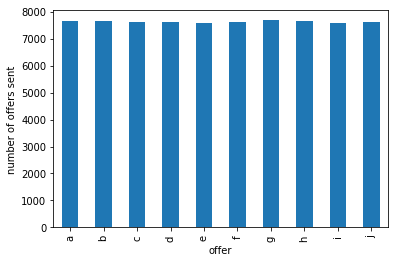

In [ ]:
out.groupby(by='offer')['completed'].count().plot(kind='bar')
plt.ylabel('number of offers sent');

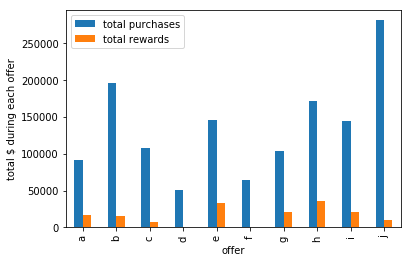

In [ ]:
out.groupby(by='offer')['Tpay_offer','reward'].sum().plot(kind='bar')
plt.ylabel('total $ during each offer');
plt.legend(['total purchases','total rewards' ])

In [ ]:
cmp=out.groupby(by='offer')['Tpay_offer','reward'].sum()

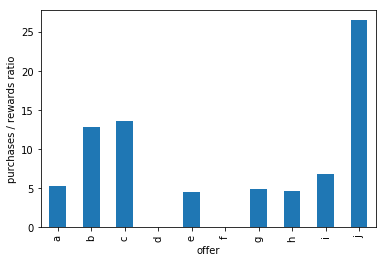

In [ ]:
(cmp['Tpay_offer']/cmp['reward']).plot(kind='bar')
plt.ylabel('purchases / rewards ratio');

In [ ]:
profile_all.head()

,age,became_member_on,gender,person,income,joined_year,joined_month,joined_week,gender_num,user_time
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,2,6,-1,529
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,28,0,376
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,7,28,-1,14
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,19,0,443
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,8,31,-1,356


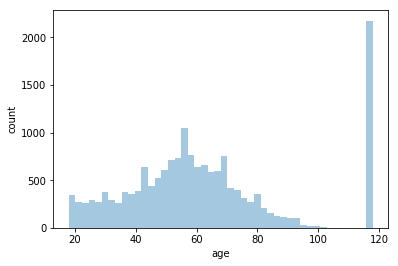

In [ ]:
sns.distplot(profile_all['age'],kde=False);
plt.ylabel('count');


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


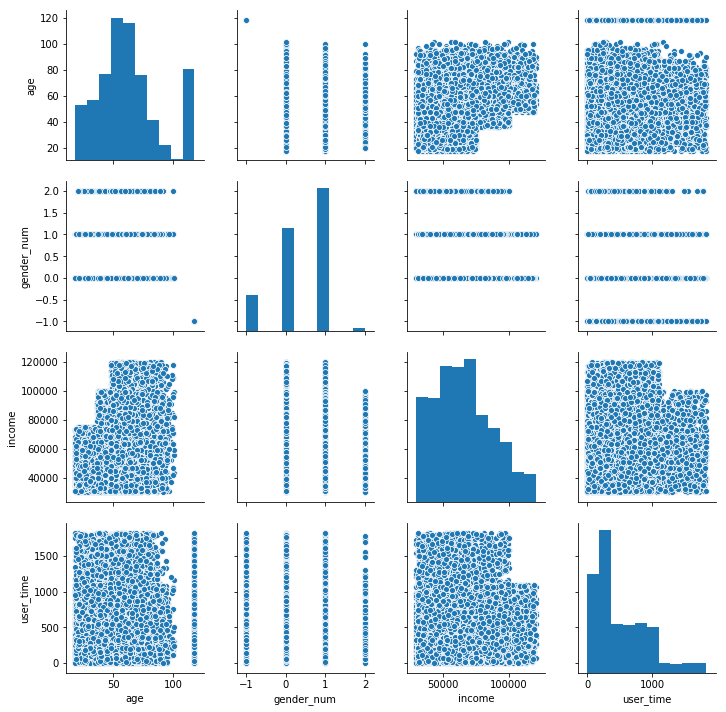

In [ ]:
sns.pairplot(profile_all[['age','gender_num','income','user_time']])


In [ ]:
pout=out.groupby(by='person')['offer'].agg('count')

In [ ]:
profile_all['incorrect_age']=profile_all.age>102
profile_all['incorrect_age'].value_counts(normalize=True)


False    0.872059
True     0.127941
Name: incorrect_age, dtype: float64

Text(0, 0.5, 'count')

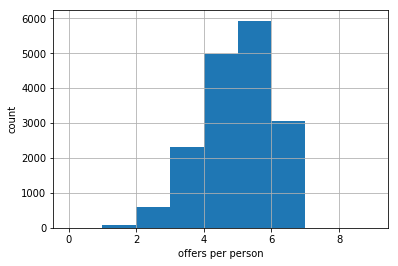

In [ ]:
pout.hist(bins=range(0,10))
plt.xlabel('offers per person')
plt.ylabel('count')

In [ ]:
pout=out.groupby(by='offer')['person'].agg('count')

NameError: ignored

,gender,percentange completed
0,F,45.443619
1,M,35.739201
2,O,49.454148


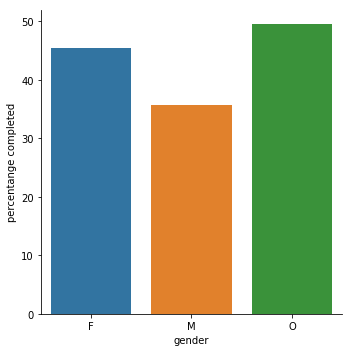

In [ ]:
o_cmp_ratio=out.groupby(by='gender')['completed'].value_counts(normalize=True)
o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values('completed')==True,:]
o_cmp=100.*o_cmp.droplevel(level='completed').to_frame()

o_cmp=o_cmp.stack().reset_index().drop(columns=['level_1']).rename(columns={0:'percentange completed'})
display(o_cmp)

sns.catplot(x='gender',y='percentange completed',data=o_cmp,kind='bar')

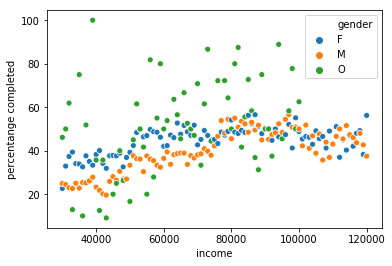

In [9]:
o_cmp_ratio=out.groupby(by=['income','gender'])['completed'].value_counts(normalize=True)
o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values('completed')==True,:]
o_cmp=100.*o_cmp.droplevel(level='completed').to_frame()

o_cmp=o_cmp.stack().reset_index().drop(columns=['level_2']).rename(columns={0:'percentange completed'})


sns.scatterplot(x='income',y='percentange completed', hue='gender',data=o_cmp)

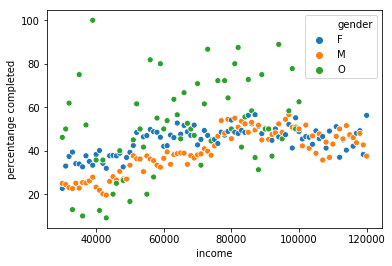

In [13]:
o_cmp_ratio=out.groupby(by=['income','gender'])['completed'].value_counts(normalize=True)
o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values('completed')==True,:]
o_cmp=100.*o_cmp.droplevel(level='completed').to_frame()

o_cmp=o_cmp.stack().reset_index().drop(columns=['level_2']).rename(columns={0:'percentange completed'})


sns.scatterplot(x='income',y='percentange completed', hue='gender',data=o_cmp)

In [20]:
o_cmp_counts=out.groupby(by=['binned_income','gender'])['completed'].value_counts()

o_cmp_true=o_cmp_counts.loc[o_cmp_counts.index.get_level_values('completed')==True,:]
o_cmp_true=o_cmp_true.droplevel(level='completed').to_frame()
o_cmp_true['total']=out.groupby(by=['binned_income','gender'])['completed'].count()
o_cmp_true=o_cmp_true.reset_index()


In [21]:
from statsmodels.stats.proportion import proportion_confint


o_cmp_counts=out.groupby(by=['binned_income','gender'])['completed'].value_counts()

o_cmp_true=o_cmp_counts.loc[o_cmp_counts.index.get_level_values('completed')==True,:]
o_cmp_true=o_cmp_true.droplevel(level='completed').to_frame()
o_cmp_true['total']=out.groupby(by=['binned_income','gender'])['completed'].count()
o_cmp_true=o_cmp_true.reset_index()

lb,ub= proportion_confint(o_cmp_true['completed'],o_cmp_true['total'])
o_cmp_true['lb']=lb
o_cmp_true['ub']=ub
ym=o_cmp_true['mean']=o_cmp_true['completed']/o_cmp_true['total']


In [60]:
from statsmodels.stats.proportion import proportion_confint

def grouped_proportions(df,group_list,binary_variable,alpha=0.05,method='normal'):

    counts=df.groupby(by=group_list)[binary_variable].value_counts()

    out=counts.loc[counts.index.get_level_values(binary_variable)==True,:]
    out=out.droplevel(level=binary_variable).to_frame()

    out['total']=df.groupby(by=group_list)[binary_variable].count()
    out=out.reset_index()

    lb,ub= proportion_confint(out[binary_variable],out['total'],alpha=alpha, method=method)
    out['lb']=lb
    out['ub']=ub
    out['mean']=out[binary_variable]/out['total']

    return(out)

In [61]:
def plot_proportions( df,col_groups, col_x ,alpha=0.2):
    values=np.unique(df[col_groups])
    colors=sns.color_palette('muted',values.shape[0])
    
    n=0
    for value in values:

        cc=df.loc[df[col_groups]==value]

        xm=np.array(cc[col_x].values)

        alpha_line=np.max((alpha+.6,1))
        plt.plot(xm,100.*cc['lb'].values,alpha=alpha_line,color=colors[n],label=value)
        plt.plot(xm,100.*cc['ub'].values,alpha=alpha_line,color=colors[n])
        plt.fill_between(xm,100.*cc['lb'],100.*cc['ub'],alpha=alpha,color=colors[n])
        
        n+=1
    plt.xlabel(col_x)


In [62]:
cmp=grouped_proportions(out,['binned_income','gender'],'completed')

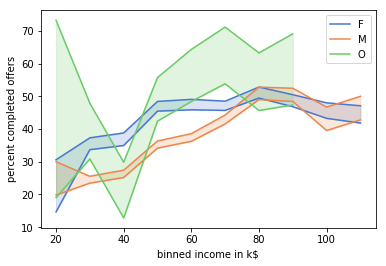

In [63]:
plot_proportions( cmp,'gender', 'binned_income' ,alpha=0.2);
plt.legend();
plt.xlabel('binned income in k$');
plt.ylabel('percent completed offers');



In [57]:
cmp=grouped_proportions(out,['binned_age','gender'],'completed')

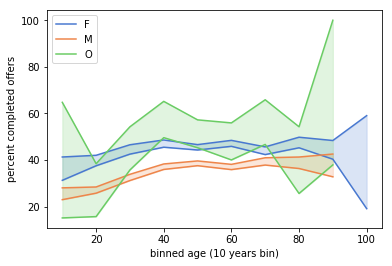

In [59]:
plot_proportions( cmp,'gender', 'binned_age' ,alpha=0.2);
plt.legend();
plt.xlabel('binned age (10 years bin)');
plt.ylabel('percent completed offers');

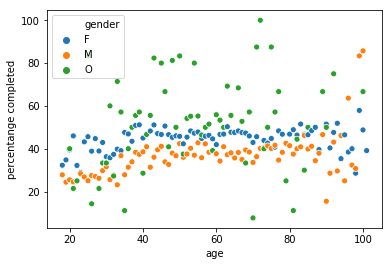

In [ ]:
o_cmp_ratio=out.groupby(by=['age','gender'])['completed'].value_counts(normalize=True)
o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values('completed')==True,:]
o_cmp=100.*o_cmp.droplevel(level='completed').to_frame()

o_cmp=o_cmp.stack().reset_index().drop(columns=['level_2']).rename(columns={0:'percentange completed'})


sns.scatterplot(x='age',y='percentange completed', hue='gender',data=o_cmp)

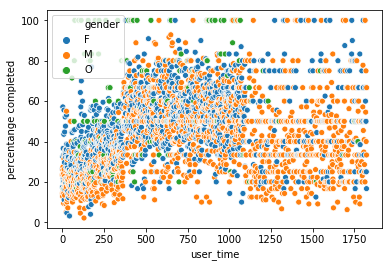

In [ ]:
o_cmp_ratio=out.groupby(by=['user_time','gender'])['completed'].value_counts(normalize=True)
o_cmp=o_cmp_ratio.loc[o_cmp_ratio.index.get_level_values('completed')==True,:]
o_cmp=100.*o_cmp.droplevel(level='completed').to_frame()

o_cmp=o_cmp.stack().reset_index().drop(columns=['level_2']).rename(columns={0:'percentange completed'})


sns.scatterplot(x='user_time',y='percentange completed', hue='gender',data=o_cmp)

Text(0, 0.5, 'mean $ purchases during offer')

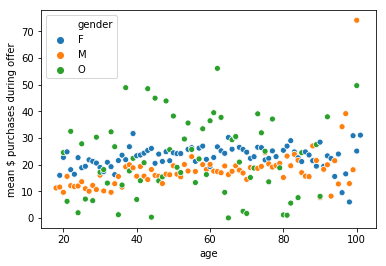

In [ ]:
o_cmp_ratio=out.groupby(by=['age','gender'])['Tpay_offer'].mean()
o_cmp=o_cmp_ratio.reset_index() 

sns.scatterplot(x='age',y='Tpay_offer', hue='gender',data=o_cmp)
plt.ylabel('mean $ purchases during offer')

/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, '95% confidence interval')

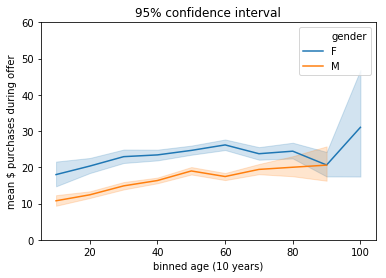

In [ ]:
sns.lineplot(x='binned_age',y='Tpay_offer', hue='gender',data=out.loc[out.gender!='O'],ci=95)
plt.ylabel('mean $ purchases during offer')
plt.xlabel('binned age (10 years)')

plt.ylim(0,60)
plt.title('95% confidence interval')

Text(0, 0.5, 'mean $ purchases during offer')

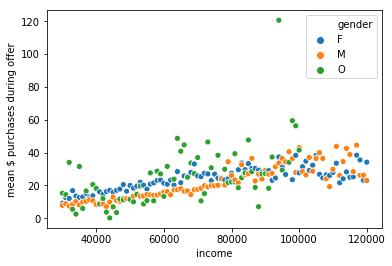

In [ ]:
o_cmp_ratio=out.groupby(by=['income','gender'])['Tpay_offer'].mean()
o_cmp=o_cmp_ratio.reset_index() 

sns.scatterplot(x='income',y='Tpay_offer', hue='gender',data=o_cmp)
plt.ylabel('mean $ purchases during offer')

/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


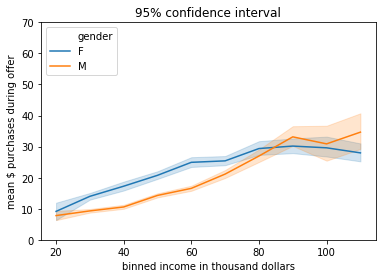

In [ ]:

sns.lineplot(x='binned_income',y='Tpay_offer', hue='gender',data=out.loc[out.gender!='O'],ci=95)
plt.xlabel('binned income in thousand dollars')

plt.ylabel('mean $ purchases during offer')
plt.ylim(0,70)
plt.title('95% confidence interval')
plt.legend(loc=2);

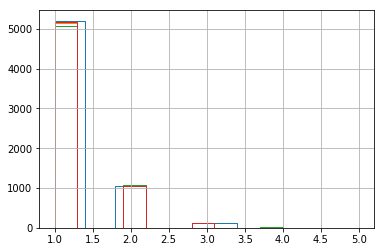

In [ ]:
(out.loc[out.offer=='a','person'].value_counts()).hist(histtype='step')
(out.loc[out.offer=='b','person'].value_counts()).hist(histtype='step')
(out.loc[out.offer=='c','person'].value_counts()).hist(histtype='step')
(out.loc[out.offer=='d','person'].value_counts()).hist(histtype='step')

# out.groupby(by='offer')['person'].value_counts()


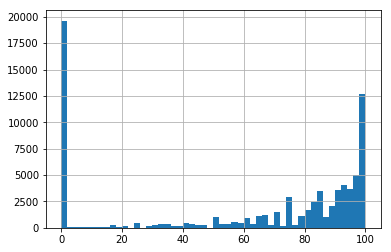

In [ ]:
out['percent_viewed']=100*out['duration_effective']/out['duration_hours']
out['percent_viewed'].hist(bins=50)


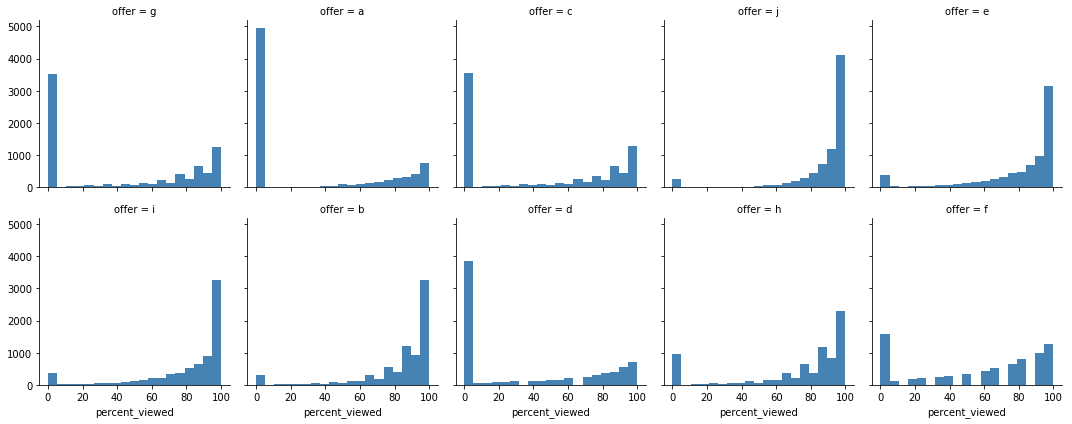

In [ ]:
g = sns.FacetGrid(out, col="offer",  margin_titles=True, col_wrap=5)
bins = np.linspace(0, 100,20)
g.map(plt.hist, 'percent_viewed', color="steelblue", bins=bins)

In [ ]:
out.groupby(by='offer')['percent_viewed'].agg(['mean','median'])

,mean,median
offer,,
a,28.598396,0.000000
b,84.349426,92.857143
c,43.030754,39.285714
d,36.337305,0.000000
e,79.758330,90.000000
f,57.767787,66.666667
g,43.065558,39.285714
h,73.315953,85.714286
i,80.106327,90.000000


In [ ]:
(out['percent_viewed']*out['duration_hours']/100.).mean()l

95.79540359479266

In [ ]:
pout=out.groupby(by='person')['Tpay_offers_tot','Trewards_tot','Tpay_out','Avg_D_nOS','income','gender_num','age'].agg('mean')
pout['gender']='M'
pout.loc[pout.gender_num==0,'gender']='F'
pout.loc[pout.gender_num==2,'gender']='O'


/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


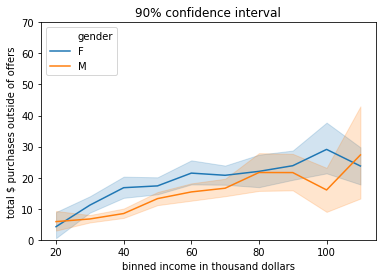

In [ ]:
pout['binned_income'] = pd.cut(pout['income'],bins= np.arange(0,14)*1e4,labels=np.arange(0,13)*10)

#sns.lineplot(x='binned_income',y='Tpay_out', hue='gender',data=pout[(pout.gender_num==0) | (pout.gender_num==1)],ci=90)
sns.lineplot(x='binned_income',y='Tpay_out', hue='gender',data=pout.loc[pout.gender!='O'],ci=90,hue_order=['F','M'])
plt.ylabel('total $ purchases outside of offers')
plt.xlabel('binned income in thousand dollars')

plt.ylim(0,70)
plt.title('90% confidence interval')
plt.legend(loc=2);

/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


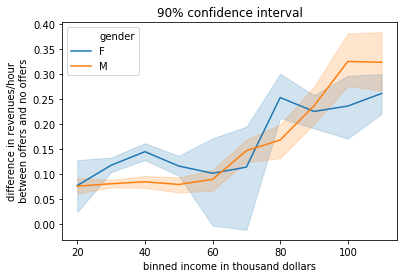

In [ ]:

sns.lineplot(x='binned_income',y='Avg_D_nOS', hue='gender',data=pout[(pout.gender_num==0) | (pout.gender_num==1)],ci=90,hue_order=['F','M'])
plt.ylabel('difference in revenues/hour\n between offers and no offers')
plt.xlabel('binned income in thousand dollars')

# plt.ylim(0,70)
plt.title('90% confidence interval')
plt.legend(loc=2);

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130])

person
0009655768c64bdeb2e877511632db8f     70
00116118485d4dfda04fdbaba9a87b5c    NaN
0011e0d4e6b944f998e987f904e8c1e5     50
0020c2b971eb4e9188eac86d93036a77     80
0020ccbbb6d84e358d3414a3ff76cffd     50
Name: binned_income, dtype: category
Categories (13, int64): [0 < 10 < 20 < 30 ... 90 < 100 < 110 < 120]

/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


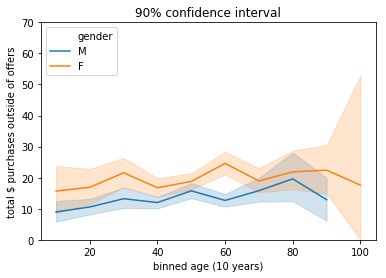

In [ ]:
pout['binned_age'] = pd.cut(pout['age'],bins= np.arange(0,120,10) ,labels=np.arange(0,120,10)[:-1])

sns.lineplot(x='binned_age',y='Tpay_out', hue='gender',data=pout[(pout.gender_num==0) | (pout.gender_num==1)],ci=90)
plt.ylabel('total $ purchases outside of offers')
plt.xlabel('binned age (10 years)')

plt.ylim(0,70)
plt.title('90% confidence interval')
plt.legend(loc=2);

/usr/local/lib/python3.6/dist-packages/seaborn/algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


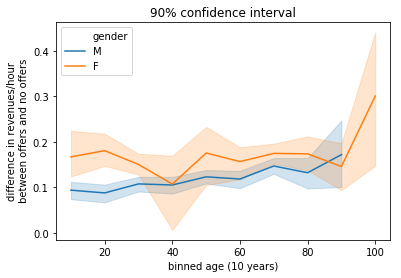

In [ ]:
sns.lineplot(x='binned_age',y='Avg_D_nOS', hue='gender',data=pout[(pout.gender_num==0) | (pout.gender_num==1)],ci=90)
plt.ylabel('difference in revenues/hour\n between offers and no offers')
plt.xlabel('binned age (10 years)')

# plt.ylim(0,70)
plt.title('90% confidence interval')
plt.legend(loc=2);


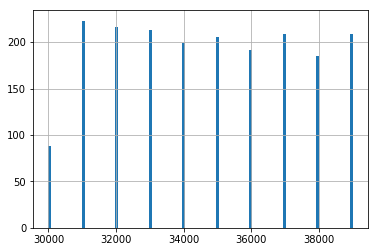

In [ ]:
profile_all.income[profile_all.income<40000].hist(bins=100)
